In [164]:
import pandas as pd
%pip install pm4py
import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

Note: you may need to restart the kernel to use updated packages.


In [165]:
#get log from XES file
log_permit = xes_importer.apply("C:/Users/chiar/OneDrive/Desktop/BIS EXAM 2/PermitLog.xes/PermitLog.xes")


# Convert to DataFrame
df_permit = log_converter.apply(log_permit, variant=log_converter.Variants.TO_DATA_FRAME)


df_permit['time:timestamp'] = pd.to_datetime(df_permit['time:timestamp'])
#df_permit['concept:name'] = df_permit['concept:name'].astype(str)

# Verify
print(f"Number of cases: {len(log_permit)}")
print(f"Number of events: {sum(len(trace) for trace in log_permit)}")

df_permit

parsing log, completed traces :: 100%|██████████| 7065/7065 [00:03<00:00, 2183.28it/s]


Number of cases: 7065
Number of events: 86581


,id,org:resource,concept:name,time:timestamp,org:role,case:OrganizationalEntity,case:ProjectNumber,case:TaskNumber,case:dec_id_0,case:ActivityNumber,...,case:Cost Type_14,case:Cost Type_10,case:Cost Type_11,case:Cost Type_12,case:Task_5,case:Task_4,case:Task_9,case:Task_8,case:Task_7,case:Task_6
0,rv_travel permit 76455_6,STAFF MEMBER,Start trip,2016-10-05 00:00:00+00:00,EMPLOYEE,organizational unit 65458,UNKNOWN,UNKNOWN,declaration 76457,activity 46005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,rv_travel permit 76455_7,STAFF MEMBER,End trip,2016-10-05 00:00:00+00:00,EMPLOYEE,organizational unit 65458,UNKNOWN,UNKNOWN,declaration 76457,activity 46005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,st_step 76459_0,STAFF MEMBER,Permit SUBMITTED by EMPLOYEE,2017-04-06 13:32:10+00:00,EMPLOYEE,organizational unit 65458,UNKNOWN,UNKNOWN,declaration 76457,activity 46005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,st_step 76460_0,STAFF MEMBER,Permit FINAL_APPROVED by SUPERVISOR,2017-04-06 13:32:28+00:00,SUPERVISOR,organizational unit 65458,UNKNOWN,UNKNOWN,declaration 76457,activity 46005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,st_step 76461_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-04-07 13:38:14+00:00,EMPLOYEE,organizational unit 65458,UNKNOWN,UNKNOWN,declaration 76457,activity 46005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86576,st_step 13113_0,STAFF MEMBER,Permit APPROVED by ADMINISTRATION,2018-12-30 15:11:51+00:00,ADMINISTRATION,organizational unit 65464,project 13110,task 427,NaN,UNKNOWN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86577,rv_travel permit 13108_6,STAFF MEMBER,Start trip,2019-01-02 00:00:00+00:00,EMPLOYEE,organizational unit 65464,project 13110,task 427,NaN,UNKNOWN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86578,st_step 13112_0,STAFF MEMBER,Permit APPROVED by SUPERVISOR,2019-01-02 09:11:23+00:00,SUPERVISOR,organizational unit 65464,project 13110,task 427,NaN,UNKNOWN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86579,st_step 13114_0,STAFF MEMBER,Permit FINAL_APPROVED by DIRECTOR,2019-01-07 14:03:29+00:00,DIRECTOR,organizational unit 65464,project 13110,task 427,NaN,UNKNOWN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
# Sort by case ID and timestamp domestic
df_permit = df_permit.sort_values(by=['case:concept:name', 'time:timestamp'])

# Get start and end activities for each case
start_activities = pm4py.get_start_activities(df_permit)
end_activities = pm4py.get_end_activities(df_permit)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))


Start activities: {'Permit SUBMITTED by EMPLOYEE': 6319, 'Start trip': 734, 'Permit SAVED by EMPLOYEE': 12}
End activities: {'Payment Handled': 5474, 'Send Reminder': 991, 'End trip': 453, 'Permit REJECTED by EMPLOYEE': 31, 'Permit FINAL_APPROVED by SUPERVISOR': 14, 'Declaration SAVED by EMPLOYEE': 28, 'Permit SAVED by EMPLOYEE': 4, 'Declaration REJECTED by EMPLOYEE': 28, 'Request Payment': 1, 'Declaration REJECTED by SUPERVISOR': 1, 'Permit REJECTED by MISSING': 38, 'Declaration REJECTED by MISSING': 2}


In [167]:


# Filter log: da 'Permit SUBMITTED by EMPLOYEE' a 'Payment Handled'
filter_log_permit = pm4py.filter_start_activities(log_permit, ['Permit SUBMITTED by EMPLOYEE'])
filter_log_permit = pm4py.filter_end_activities(filter_log_permit, ['Payment Handled'])

# Sub-log 1: da 'Permit SUBMITTED by EMPLOYEE' a 'End trip'
end_trip_log = pm4py.filter_start_activities(log_permit, ['Permit SUBMITTED by EMPLOYEE'])
end_trip_log = pm4py.filter_end_activities(end_trip_log, ['End trip'])

# Sub-log 2: da 'Permit SUBMITTED by EMPLOYEE' a 'Send Reminder'
send_reminder_log = pm4py.filter_start_activities(log_permit, ['Permit SUBMITTED by EMPLOYEE'])
send_reminder_log = pm4py.filter_end_activities(send_reminder_log, ['Send Reminder'])

# Sub-log 3: da 'Start trip' a 'Payment Handled'
no_permit_but_paid_log = pm4py.filter_start_activities(log_permit, ['Start trip'])
no_permit_but_paid_log = pm4py.filter_end_activities(no_permit_but_paid_log, ['Payment Handled'])

# Count cases
def count_cases(filtered_log):
    return len(set(trace.attributes['concept:name'] for trace in filtered_log))

print("Main filtered log (submit → payment):", count_cases(filter_log_permit))
print("Submit → End trip:", count_cases(end_trip_log))
print("Submit → Send Reminder:", count_cases(send_reminder_log))
print("Start trip → Payment:", count_cases(no_permit_but_paid_log))


Main filtered log (submit → payment): 4898
Submit → End trip: 410
Submit → Send Reminder: 917
Start trip → Payment: 576


In [168]:
#REMOVE CASES WITHOUT PERMIT APPROVAL

df_filtered_permit = log_converter.apply(filter_log_permit, variant=log_converter.Variants.TO_DATA_FRAME)

all_case_ids = df_filtered_permit['case:concept:name'].unique()


cases_with_approval = df_filtered_permit[
    df_filtered_permit['concept:name'] == 'Permit FINAL_APPROVED by SUPERVISOR'
]['case:concept:name'].unique()

cases_without_approval = set(all_case_ids) - set(cases_with_approval)

print(f"Total cases: {len(all_case_ids)}")
print(f"Cases with final approve: {len(cases_with_approval)}")
print(f"Cases without final approve: {len(cases_without_approval)}")


df_no_approval = df_filtered_permit[df_filtered_permit['case:concept:name'].isin(cases_without_approval)]

df_filtered_permit = df_filtered_permit[df_filtered_permit['case:concept:name'].isin(cases_with_approval)]

log_permit_approved = log_converter.apply(df_filtered_permit, variant=log_converter.Variants.TO_EVENT_LOG)


Total cases: 4898
Cases with final approve: 4381
Cases without final approve: 517


In [169]:
#remove cases with declaration delayed more than 60 days after trip end
# 1. get time between End trip and Declaration SUBMITTED
def time_after_trip(gruppo):
    if 'End trip' in gruppo['concept:name'].values and 'Declaration SUBMITTED by EMPLOYEE' in gruppo['concept:name'].values:
        t_end = gruppo[gruppo['concept:name'] == 'End trip']['time:timestamp'].iloc[0]
        t_decl = gruppo[gruppo['concept:name'] == 'Declaration SUBMITTED by EMPLOYEE']['time:timestamp'].iloc[0]
        delta_days = (t_decl - t_end).total_seconds() / 86400
        return delta_days
    return np.nan

# 2. apply function to each case
time_after_trip = df_filtered_permit.groupby("case:concept:name").apply(time_after_trip).dropna()

# 3. identify violating cases
casi_fuori_policy = time_after_trip[time_after_trip > 60]
case_ids_fuori_policy = set(casi_fuori_policy.index)

# 4. remove those cases from the DataFrame
df_filtered_permit= df_filtered_permit[
    ~df_filtered_permit['case:concept:name'].isin(case_ids_fuori_policy)
]

# 5. Output riepilogativo
print(f"Casi totali con dichiarazione post-viaggio validi: {len(time_after_trip)}")
print(f"Rimossi {len(casi_fuori_policy)} casi con dichiarazione oltre i 60 giorni ({len(casi_fuori_policy)/len(time_after_trip)*100:.2f}%)")
print(f"Casi rimasti nel dataset: {df_filtered_permit['case:concept:name'].nunique()}")



Casi totali con dichiarazione post-viaggio validi: 4379
Rimossi 139 casi con dichiarazione oltre i 60 giorni (3.17%)
Casi rimasti nel dataset: 4242


C:\Users\chiar\AppData\Local\Temp\ipykernel_48700\693769767.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_after_trip = df_filtered_permit.groupby("case:concept:name").apply(time_after_trip).dropna()


Lead time mean: 72.25 giorni
Lead time median: 62.21 giorni


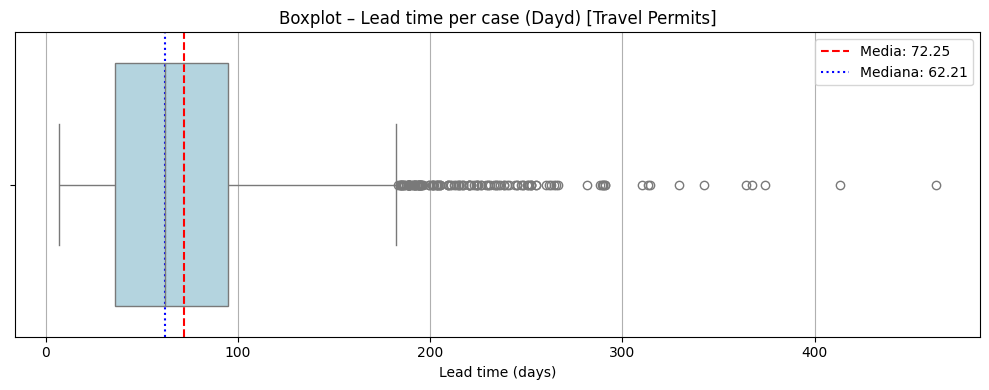

In [170]:
#LEAD TIME
df_filtered_permit = log_converter.apply(log_permit_approved, variant=log_converter.Variants.TO_DATA_FRAME)


lead_time_p = df_filtered_permit.groupby("case:concept:name")["time:timestamp"].agg(
    lambda x: (x.max() - x.min()).total_seconds()
)


lead_time_days_p = lead_time_p / 86400
avg_lead_time_days_p = lead_time_days_p.mean()
median_lead_time_days_p = lead_time_days_p.median()

# Output testuale
print(f"Lead time mean: {avg_lead_time_days_p:.2f} giorni")
print(f"Lead time median: {median_lead_time_days_p:.2f} giorni")

# Boxplot della distribuzione dei lead time
plt.figure(figsize=(10, 4))
sns.boxplot(x=lead_time_days_p, color='lightblue')
plt.title("Boxplot – Lead time per case (Dayd) [Travel Permits]")
plt.xlabel("Lead time (days)")
plt.grid(True, axis='x')

# Annotazioni: media e mediana
plt.axvline(avg_lead_time_days_p, color='red', linestyle='--', label=f'Media: {avg_lead_time_days_p:.2f}')
plt.axvline(median_lead_time_days_p, color='blue', linestyle=':', label=f'Mediana: {median_lead_time_days_p:.2f}')
plt.legend()

plt.tight_layout()
plt.show()


Test di Shapiro-Wilk – p-value: 0.00000
Distribution id NOT normal (p < 0.05)
Mean: 72.25 days – Deviazione standard: 47.80 days


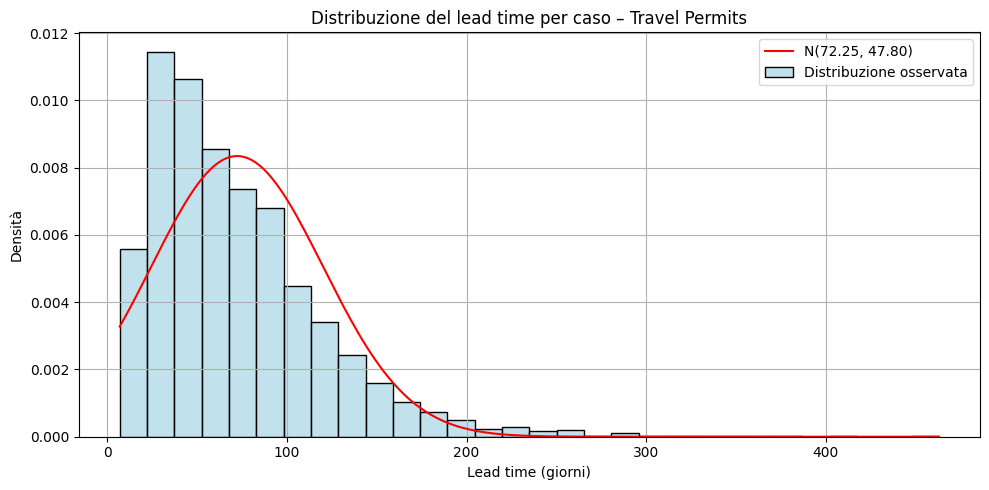

In [171]:
from scipy.stats import norm
# Campione massimo 500 per test di Shapiro-Wilk
sample_p = lead_time_days_p
if len(lead_time_days_p) > 500:
    sample_p = lead_time_days_p.sample(500, random_state=42)

# Test di Shapiro-Wilk
shapiro_stat_p, shapiro_pval_p = stats.shapiro(sample_p)
print(f"Test di Shapiro-Wilk – p-value: {shapiro_pval_p:.5f}")
if shapiro_pval_p < 0.05:
    print("Distribution id NOT normal (p < 0.05)")
else:
    print("Distribution is normal (p ≥ 0.05)")


mu_p = lead_time_days_p.mean()
sigma_p = lead_time_days_p.std()
print(f"Mean: {mu_p:.2f} days – Deviazione standard: {sigma_p:.2f} days")


plt.figure(figsize=(10, 5))

sns.histplot(lead_time_days_p, stat="density", bins=30, kde=False, color="lightblue", label="Distribuzione osservata")

# KDE stimata
#sns.kdeplot(lead_time_days_p, color="blue", label="KDE osservata")

# normal distribution curve
x = np.linspace(lead_time_days_p.min(), lead_time_days_p.max(), 200)
plt.plot(x, norm.pdf(x, mu_p, sigma_p), color='red', label=f'N({mu_p:.2f}, {sigma_p:.2f})')

# Etichette e legenda
plt.title("Distribuzione del lead time per caso – Travel Permits")
plt.xlabel("Lead time (giorni)")
plt.ylabel("Densità")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [172]:
# IQR
q1_lt_p = lead_time_days_p.quantile(0.25)
q3_lt_p = lead_time_days_p.quantile(0.75)
iqr_lt_p = q3_lt_p - q1_lt_p

lower_bound_lt_p = q1_lt_p - 1.5 * iqr_lt_p
upper_bound_lt_p = q3_lt_p + 1.5 * iqr_lt_p

# Selection outlier 
outliers_lt_p = lead_time_days_p[(lead_time_days_p < lower_bound_lt_p) | (lead_time_days_p > upper_bound_lt_p)]
n_outliers_lt_p = len(outliers_lt_p)

total_cases_p = len(lead_time_days_p)

perc_outliers_lt_p = n_outliers_lt_p / total_cases_p * 100

# Output
print(f"Total cases: {total_cases_p}")
print(f" Outlier per duration (lead time): {n_outliers_lt_p} casi ({perc_outliers_lt_p:.2f}%)")


Total cases: 4381
 Outlier per duration (lead time): 133 casi (3.04%)


In [173]:

outlier_case_ids_p = set(outliers_lt_p.index)

#remove outliers from df_filtered_permit
df_filtered_permit = df_filtered_permit[
    ~df_filtered_permit["case:concept:name"].isin(outlier_case_ids_p)
]


print(f"NUmber of cases after removing outlier: {df_filtered_permit['case:concept:name'].nunique()}")


NUmber of cases after removing outlier: 4248


In [174]:
#RICALCOLO LEAD TIME DOPO RIMOZIONE OUTLIER

lead_times_p = df_filtered_permit.groupby("case:concept:name")["time:timestamp"].agg(
    lambda x: (x.max() - x.min()).total_seconds()
)


lead_time_days_p = lead_times_p / 86400
avg_lead_time_days_p = lead_time_days_p.mean()
median_lead_time_days_p = lead_time_days_p.median()

# Output adjusted
print(f"New mean lead time: {avg_lead_time_days_p:.2f} giorni")
print(f"New median lead time: {median_lead_time_days_p:.2f} giorni")


New mean lead time: 67.35 giorni
New median lead time: 60.08 giorni


In [175]:
#enough time between permit approval and trip start

df_app_start = df_filtered_permit[
    df_filtered_permit['concept:name'].isin(['Permit FINAL_APPROVED by SUPERVISOR', 'Start trip'])
]

df_app_start = df_app_start.sort_values(by=['case:concept:name', 'time:timestamp'])

#get difference for each case
def delta(gruppo):
    if 'Permit FINAL_APPROVED by SUPERVISOR' in gruppo['concept:name'].values and 'Start trip' in gruppo['concept:name'].values:
        t_approvazione = gruppo[gruppo['concept:name'] == 'Permit FINAL_APPROVED by SUPERVISOR']['time:timestamp'].iloc[0]
        t_partenza = gruppo[gruppo['concept:name'] == 'Start trip']['time:timestamp'].iloc[0]
        return (t_partenza - t_approvazione).total_seconds() / 86400  
    else:
        return np.nan

# Apply function
pre_trip = df_app_start.groupby("case:concept:name").apply(delta).dropna()


mean_confirmation_time = pre_trip.mean()
median_confirmation_time = pre_trip.median()

print(f"Mean Advance confirmation before trip: {mean_confirmation_time:.2f} days")



# cases with notice <1 day
pre_trip_min = pre_trip[pre_trip < 1]

# cases with approval after trip start
error_cases = pre_trip[pre_trip < 0]

# Output
print(f"Cases with notice < 1 day: {len(pre_trip_min)} ({len(pre_trip_min) / len(pre_trip) * 100:.2f}%)")
print(f"cases approved after trip start: {len(error_cases)} ({len(error_cases) / len(pre_trip) * 100:.2f}%)")

# Opzionale: ispezione dettagliata dei casi anomali
df_errors = df_filtered_permit[df_filtered_permit['case:concept:name'].isin(error_cases.index)]



Mean Advance confirmation before trip: 33.29 days
Cases with notice < 1 day: 481 (11.32%)
cases approved after trip start: 339 (7.98%)


C:\Users\chiar\AppData\Local\Temp\ipykernel_48700\2056151714.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pre_trip = df_app_start.groupby("case:concept:name").apply(delta).dropna()


In [176]:
#remove cases with permit after start trip

case_ids_error = set(error_cases.index)

df_filtered_permit = df_filtered_permit[
    ~df_filtered_permit["case:concept:name"].isin(case_ids_error)
]


filter_log_permit = log_converter.apply(df_filtered_permit, variant=log_converter.Variants.TO_EVENT_LOG)

# Rimuovi anche dal Series dell’anticipo per mantenerlo coerente
anticipo_viaggio = pre_trip[~pre_trip.index.isin(case_ids_error)]



In [177]:
#Mean time between specific activities
def intra_activity_time(df, attività1, attività2):
    results = []

    for case_id, gruppo in df.groupby("case:concept:name"):
        att1 = gruppo[gruppo["concept:name"] == attività1]
        att2 = gruppo[gruppo["concept:name"] == attività2]

        if not att1.empty and not att2.empty:
            t1 = att1["time:timestamp"].iloc[0]
            t2 = att2["time:timestamp"].iloc[0]
            delta_days = (t2 - t1).total_seconds() / 86400
            results.append(delta_days)

    if results:
        media = np.mean(results)
        mediana = np.median(results)
        print(f"⏱️ Tempo medio da '{attività1}' a '{attività2}': {media:.2f} giorni")
        
       
    else:
        print(f"Nessun caso con entrambe le attività '{attività1}' e '{attività2}' trovate.")
    
    return results

permit_submit_appr= intra_activity_time(df_filtered_permit, "Permit SUBMITTED by EMPLOYEE", "Permit FINAL_APPROVED by SUPERVISOR")
endTrip_declaration= intra_activity_time(df_filtered_permit, "End trip", "Declaration SUBMITTED by EMPLOYEE")
endTrip_sendReminder= intra_activity_time(df_filtered_permit, "End trip", "Send Reminder")
requestPay_PaymHandle= intra_activity_time(df_filtered_permit, "Request For Payment SUBMITTED by EMPLOYEE", "Payment Handled")



⏱️ Tempo medio da 'Permit SUBMITTED by EMPLOYEE' a 'Permit FINAL_APPROVED by SUPERVISOR': 3.07 giorni
⏱️ Tempo medio da 'End trip' a 'Declaration SUBMITTED by EMPLOYEE': 10.80 giorni
⏱️ Tempo medio da 'End trip' a 'Send Reminder': 42.52 giorni
⏱️ Tempo medio da 'Request For Payment SUBMITTED by EMPLOYEE' a 'Payment Handled': 10.46 giorni


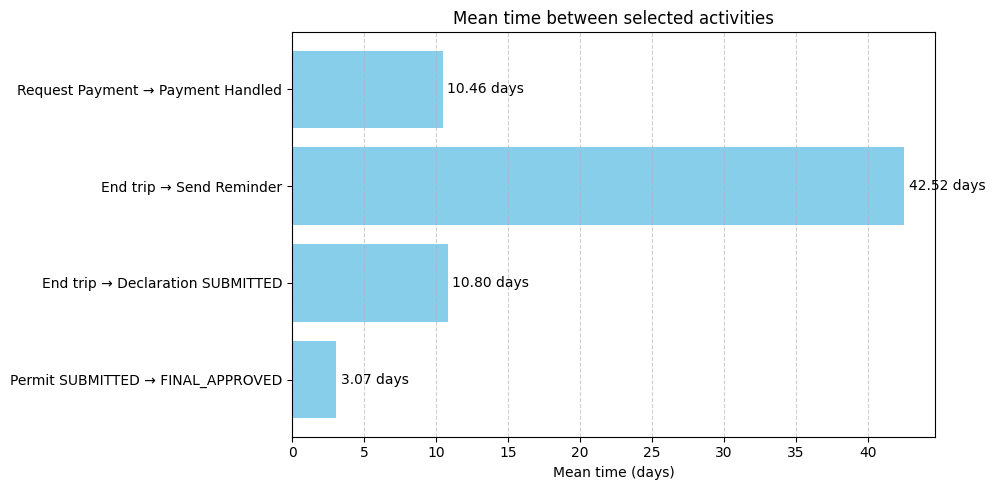

In [180]:
tempi_medi = {
    "Permit SUBMITTED → FINAL_APPROVED": np.mean(permit_submit_appr),
    "End trip → Declaration SUBMITTED": np.mean(endTrip_declaration),
    "End trip → Send Reminder": np.mean(endTrip_sendReminder),
    "Request Payment → Payment Handled": np.mean(requestPay_PaymHandle),
   
}

# Plot
plt.figure(figsize=(10, 5))
bars = plt.barh(list(tempi_medi.keys()), list(tempi_medi.values()), color='skyblue')
plt.xlabel("Mean time (days)")
plt.title("Mean time between selected activities")

for bar in bars:
    plt.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height() / 2,
             f"{bar.get_width():.2f} days", va='center')

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

📊 Casi con almeno un rework: 1713/3909 (43.82%)


C:\Users\chiar\AppData\Local\Temp\ipykernel_48700\849833711.py:25: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\chiar\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


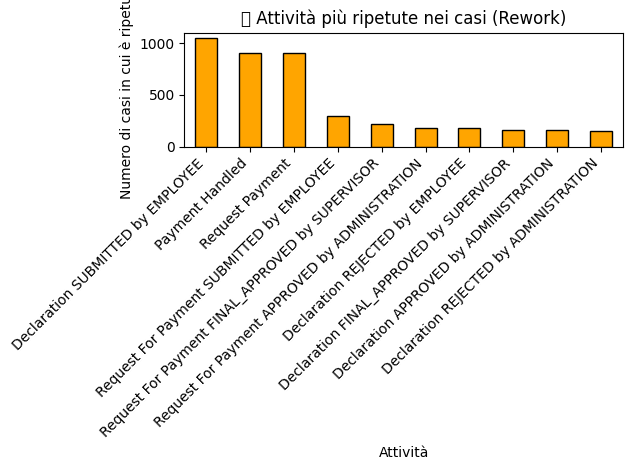

In [179]:
# Raggruppa per caso e attività e conta le occorrenze
activity_repetitions = df_filtered_permit.groupby(['case:concept:name', 'concept:name']).size().reset_index(name='count')
rework_cases = activity_repetitions[activity_repetitions['count'] > 1]
# Attività che subiscono rework
reworked_activities = rework_cases['concept:name'].value_counts()

# Casi con almeno un'attività ripetuta
cases_with_rework = rework_cases['case:concept:name'].nunique()

# Totale dei casi
total_cases = df_filtered_permit['case:concept:name'].nunique()

# Percentuale casi con rework
perc_rework = (cases_with_rework / total_cases) * 100

print(f"📊 Casi con almeno un rework: {cases_with_rework}/{total_cases} ({perc_rework:.2f}%)")

import matplotlib.pyplot as plt

reworked_activities.head(10).plot(kind='bar', color='orange', edgecolor='black')
plt.title("🔁 Attività più ripetute nei casi (Rework)")
plt.ylabel("Numero di casi in cui è ripetuta")
plt.xlabel("Attività")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

